In [1]:
import gymnasium as gym
import numpy as np
import control
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
# --- SETUP: LQR EXPERT ---
# Define physics constants
M, m, l, g = 1.0, 0.1, 0.5, 9.8
denom = l * (4.0/3.0 - m / (m + M))
A = np.array([[0, 1, 0, 0], [0, 0, -m*g/M, 0], [0, 0, 0, 1], [0, 0, g/denom, 0]])
B = np.array([[0], [1/M], [0], [-1/(denom*(M+m))]])
Q = np.diag([1.0, 1.0, 20.0, 1.0])
R = np.array([[0.1]]) # Cheap force = High performance expert
K, _, _ = control.lqr(A, B, Q, R)
K = K[0]

# --- DATA COLLECTION ---
print("Collecting Expert Data from LQR...")

# We use the standard CartPole environment logic (Continuous)
# Since Gymnasium's CartPole is discrete, we simulate the continuous physics manually here
# to ensure the dataset matches exactly what we want to train on.

def get_expert_action(state):
    # u = -Kx
    u = -np.dot(K, state)
    return np.clip(u, -10.0, 10.0) # Clip to realistic limits

# Arrays to store data
obs_data = []
act_data = []

# Simulate physics
state = np.array([0.0, 0.0, 0.5, 0.0]) # Start slightly tilted
dt = 0.02
steps = 1000

for i in range(steps):
    # 1. Get Expert Action
    action = get_expert_action(state)
    
    # 2. Store (Observation, Action) pair
    # Noise: It helps to add tiny noise to state so the agent sees diverse data
    noisy_state = state + np.random.normal(0, 0.001, size=4)
    obs_data.append(noisy_state)
    act_data.append(action)
    
    # 3. Step Physics (Dynamics)
    x, x_dot, theta, theta_dot = state
    force = action
    costheta = math.cos(theta)
    sintheta = math.sin(theta)
    temp = (force + 0.05 * theta_dot**2 * sintheta) / 1.1
    thetaacc = (9.8 * sintheta - costheta * temp) / (0.5 * (4.0/3.0 - 0.1 * costheta**2 / 1.1))
    xacc = temp - 0.05 * thetaacc * costheta / 1.1
    
    x += dt * x_dot
    x_dot += dt * xacc
    theta += dt * theta_dot
    theta_dot += dt * thetaacc
    
    # Reset if it falls or goes too far (to keep data clean)
    if abs(x) > 2.4 or abs(theta) > 0.5:
        state = np.array([0.0, 0.0, np.random.uniform(-0.5, 0.5), 0.0])
    else:
        state = np.array([x, x_dot, theta, theta_dot])

    # Every 50 steps, kick the pendulum randomly so LQR has to fight back.
    if i % 50 == 0:
        state[2] += np.random.uniform(-0.5, 0.5) # Random kick to angle

# Convert to PyTorch Tensors
X_train = torch.tensor(np.array(obs_data), dtype=torch.float32)
y_train = torch.tensor(np.array(act_data).reshape(-1, 1), dtype=torch.float32)

print(f"Dataset Created: {len(X_train)} samples.")

Dataset Created: 1000 samples.


In [3]:
# --- MODEL SETUP ---
# Simple Neural Network (MlpPolicy equivalent)
class ImitationPolicy(nn.Module):
    def __init__(self):
        super(ImitationPolicy, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 64),
            nn.Tanh(), # SB3 uses Tanh by default
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1) # Output: Force
        )

    def forward(self, x):
        return self.net(x)

model = ImitationPolicy()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.MSELoss() # Mimic the value exactly

# --- TRAINING LOOP ---
print("\nTraining Neural Network to Clone LQR...")
dataset = TensorDataset(X_train, y_train)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

epochs = 100
for epoch in range(epochs):
    total_loss = 0
    for batch_x, batch_y in loader:
        optimizer.zero_grad()
        pred_y = model(batch_x)
        loss = criterion(pred_y, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    if (epoch+1) % 2 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss / len(loader):.4f}")

print("Imitation Learning Complete.")


Training Neural Network to Clone LQR...
Epoch 2/100 | Loss: 8.1238
Epoch 4/100 | Loss: 6.5729
Epoch 6/100 | Loss: 4.7616
Epoch 8/100 | Loss: 3.9914
Epoch 10/100 | Loss: 3.3292
Epoch 12/100 | Loss: 2.5315
Epoch 14/100 | Loss: 1.7515
Epoch 16/100 | Loss: 1.0815
Epoch 18/100 | Loss: 0.5839
Epoch 20/100 | Loss: 0.3181
Epoch 22/100 | Loss: 0.2355
Epoch 24/100 | Loss: 0.1910
Epoch 26/100 | Loss: 0.1768
Epoch 28/100 | Loss: 0.1642
Epoch 30/100 | Loss: 0.1573
Epoch 32/100 | Loss: 0.1538
Epoch 34/100 | Loss: 0.1406
Epoch 36/100 | Loss: 0.1385
Epoch 38/100 | Loss: 0.1320
Epoch 40/100 | Loss: 0.1299
Epoch 42/100 | Loss: 0.1195
Epoch 44/100 | Loss: 0.1156
Epoch 46/100 | Loss: 0.1234
Epoch 48/100 | Loss: 0.1073
Epoch 50/100 | Loss: 0.1021
Epoch 52/100 | Loss: 0.0980
Epoch 54/100 | Loss: 0.0926
Epoch 56/100 | Loss: 0.0958
Epoch 58/100 | Loss: 0.0954
Epoch 60/100 | Loss: 0.0823
Epoch 62/100 | Loss: 0.0792
Epoch 64/100 | Loss: 0.0772
Epoch 66/100 | Loss: 0.0728
Epoch 68/100 | Loss: 0.0693
Epoch 70/10

In [4]:
import torch
import os

# Create a directory to keep things organized
save_dir = "models/imitation"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "lqr_clone.pth")

# --- SAVE THE MODEL ---
# We save the state_dict (weights), not the entire object.
# This is more robust and prevents errors when loading in different files.
torch.save(model.state_dict(), save_path)

print(f"Model weights saved to: {save_path}")

Model weights saved to: models/imitation\lqr_clone.pth



Testing the Cloned Agent...


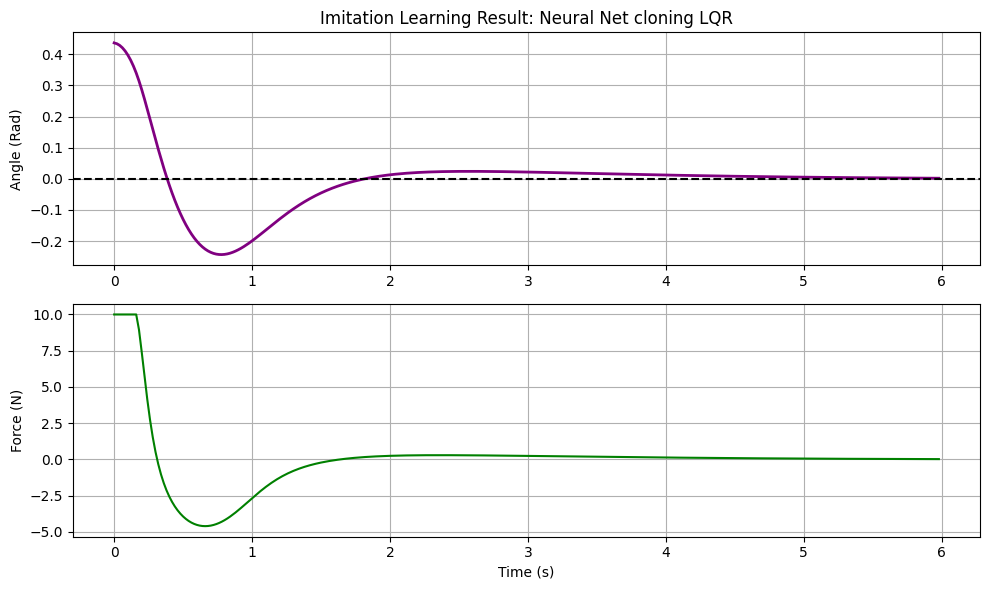

In [7]:
import matplotlib.pyplot as plt

# --- VALIDATION ---
print("\nTesting the Cloned Agent...")

state = np.array([0.0, 0.0, 0.4363, 0.0]) # Start with a TILT (~0.43 rad)
history_theta = []
history_force = []
history_time = []

model.eval() # Set to eval mode

simulation_time = 6.0 # Seconds
total_steps = int(simulation_time / dt)

for i in range(total_steps):
    current_time = i * dt
    # 1. Prepare input
    obs_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    
    # 2. Neural Net predicts action
    with torch.no_grad():
        action = model(obs_tensor).item()
    
    # 3. Physics Step
    x, x_dot, theta, theta_dot = state
    force = np.clip(action, -10, 10)
    
    costheta = math.cos(theta)
    sintheta = math.sin(theta)
    temp = (force + 0.05 * theta_dot**2 * sintheta) / 1.1
    thetaacc = (9.8 * sintheta - costheta * temp) / (0.5 * (4.0/3.0 - 0.1 * costheta**2 / 1.1))
    xacc = temp - 0.05 * thetaacc * costheta / 1.1
    
    x += dt * x_dot
    x_dot += dt * xacc
    theta += dt * theta_dot
    theta_dot += dt * thetaacc
    
    state = np.array([x, x_dot, theta, theta_dot])
    
    history_time.append(current_time)
    history_theta.append(theta)
    history_force.append(force)

# --- PLOTTING ---
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(history_time,history_theta, color='purple', linewidth=2)
plt.axhline(0, color='black', linestyle='--')
plt.title("Imitation Learning Result: Neural Net cloning LQR")
plt.ylabel("Angle (Rad)")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(history_time,history_force, color='green')
plt.ylabel("Force (N)")
plt.xlabel("Time (s)")
plt.grid(True)

plt.tight_layout()
plt.show()